In [77]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.spatial.distance as dis
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from scipy.ndimage import filters
from io import StringIO
pd.options.display.max_columns = None

In [78]:
col_cfg = pd.DataFrame(
            np.array(
                [['view','dice',1],
                ['smokingpolicy','dice',0.5],
                ['averageroomsize','fuzzydist',1],
                ['wheelchairaccessible','dice',0.5],
      #          ['adultsonly','dice',0],
                ['bedtype','dice',1],
      #          ['extrabed','dice',1],
                ['totalmaxoccupancy','fuzzydist',1],
                ['adultsallowed','fuzzydist',1],
                ['childrenallowed','fuzzydist',1],
                ['typeofroom','dice',0.5],
                ['bedroomdetails','dice',0.5],
                ['internet','dice',0.5],
                ['roomservice','dice',0.5],
                ['housekeeping','dice',0.5],
                ['conveniences','dice',0.5],
                ['bathroomtypes','dice',0.5],
                ['bedding','dice',0.5],
                ['tv','dice',0.5],
                ['kitchen','dice',0.5],
                ['kitchenfeatures','dice',0.5],
                ['climatecontrol','dice',0.5],
                ['pets','dice',0]]),
            columns = ['name','algo','weight'])
col_cfg = col_cfg.set_index('name')

In [79]:
# if any feature pair is NaN, given distance = 0.5

# dice distance
def dice_dist(ay1, ay2):
    lst = []
    for i in np.arange(len(ay1)):
        if sum(ay1[i]) == 0 or sum(ay2[i]) == 0:
            dist = 0.5
        else:
            dist = dis.dice(ay1[i], ay2[i])
        lst.append(dist)
    return np.array(lst)

#dice_dist([[1,1,0],[1,0,1],[1,1,1],[0,0,0]], [[1,0,0],[1,0,1],[0,0,0],[0,0,0]])

# fuzzy distance
def fuzzy_dist(ay1, ay2):
    lst = []
    for i in np.arange(len(ay1)):
        if np.isnan(ay1[i]) or np.isnan(ay2[i]):
            dist = 0.5
        elif ay1[i]+ay2[i] == 0:
            dist = 0
        else:
            dist = min(1, abs(ay1[i]-ay2[i])*2/(ay1[i]+ay2[i]))
        lst.append(dist)
    return np.array(lst)

#fuzzy_dist([1,0,4,np.nan], [4,0,np.nan,np.nan])

In [80]:
def calc_dist(df):
    d_list = []
    for [c,algo,w] in col_cfg.reset_index().values:
        if c+'_1' not in df.columns:
            continue
        #print(c,algo)
        if algo == 'dice':
            one_hot = MultiLabelBinarizer()
            df_concat = pd.concat([df[c+'_1'], df[c+'_2']])
            ay = one_hot.fit_transform(df_concat.astype(str).apply(
                    lambda x: [] if x == 'nan' else [s.strip() for s in x.lower().split(',')]))
            dist = dice_dist(ay[:df.shape[0]], ay[df.shape[0]:])
            d_list.append(pd.DataFrame(dist))
        elif algo == 'fuzzydist':
            dist = fuzzy_dist(df[c+'_1'].values.astype(np.float64), df[c+'_2'].values.astype(np.float64))
            d_list.append(pd.DataFrame(dist))
        else:
            print('algo [{}] not defined'.format(algo))
            
    da = pd.concat(d_list, ignore_index=True, axis=1)
    
    d_weight = col_cfg['weight'].values.astype(np.float64)
    da_mean_w = (da * d_weight).sum(axis=1, skipna=True) / ((da*0+1)*d_weight).sum(axis=1, skipna=True)
    
    df_rs = df.iloc[:,0:4].copy()
    df_rs['dist'] =  da_mean_w.values
    
    df_col_rs = pd.concat([df.iloc[:,0:4].copy(), da], ignore_index=True, axis=1)
    df_col_rs.columns = list(df.columns[0:4])+[x.rstrip('_1') for x in df.columns[4:4+len(d_list)]]
    
    return df_rs, df_col_rs

In [81]:
# lcm/lim all room amenity data
df_ra_all = pd.read_csv('LIS_EG_RTM_ALL.csv.gz', header=0)
df_ra_all.columns = [s.replace(' ','').lower() for s in df_ra_all.columns]
#df_ra_all['bedroomdetails'] = df_ra_all['bedroomdetails'].apply(
#                    lambda x: np.nan if x is np.nan or re.search("([0-9])+",str(x)) == None 
#                            else re.search("([0-9])+",str(x)).group(0)).astype(np.float64)
df_ra_all['wheelchairaccessible'] = df_ra_all['wheelchairaccessible'].apply(
                    lambda x: 'no wheelchairaccessible' if x is np.nan else x)

In [82]:
# rev+ db labeled data
room_matches = pd.read_csv('room_matches.csv', header=0)
room_matches_rt = room_matches[['roomid','competitorroomid']].drop_duplicates()
room_matches_sku = room_matches[['roomid','competitorhotelid']].drop_duplicates()

In [83]:
# calc distance for {roomid : competitor_roomid} in room_matches table
df_rt_join = pd.merge(room_matches_rt, df_ra_all, how='inner', left_on='roomid', right_on='roomtypeid')
df_rt_join = pd.merge(df_rt_join, df_ra_all, how='inner', 
                      left_on='competitorroomid', 
                      right_on='roomtypeid', 
                      suffixes=('_1', '_2'))
df_rt_join = df_rt_join[['skugroupid_1',
                'roomtypeid_1',
                'skugroupid_2',
                'roomtypeid_2',
                'view_1',
                'smokingpolicy_1',
                'averageroomsize_1',
                'wheelchairaccessible_1',
                'bedtype_1',
                'totalmaxoccupancy_1',
                'adultsallowed_1',
                'childrenallowed_1',
                'typeofroom_1',
                'bedroomdetails_1',
                'internet_1',
                'roomservice_1',
                'housekeeping_1',
                'conveniences_1',
                'bathroomtypes_1',
                'bedding_1',
                'tv_1',
                'kitchen_1',
                'kitchenfeatures_1',
                'climatecontrol_1',
                'pets_1',
                'view_2',
                'smokingpolicy_2',
                'averageroomsize_2',
                'wheelchairaccessible_2',
                'bedtype_2',
                'totalmaxoccupancy_2',
                'adultsallowed_2',
                'childrenallowed_2',
                'typeofroom_2',
                'bedroomdetails_2',
                'internet_2',
                'roomservice_2',
                'housekeeping_2',
                'conveniences_2',
                'bathroomtypes_2',
                'bedding_2',
                'tv_2',
                'kitchen_2',
                'kitchenfeatures_2',
                'climatecontrol_2',
                'pets_2']]

dm_rt,dm_col_rt = calc_dist(df_rt_join)
display(dm_rt.head(2))
display(dm_col_rt.head(2))

,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,dist
0,195,72143,123167,60128,0.230769
1,195,200053439,123167,60128,0.343590


,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,view,smokingpolicy,averageroomsize,wheelchairaccessible,bedtype,totalmaxoccupancy,adultsallowed,childrenallowed,typeofroom,bedroomdetails,internet,roomservice,housekeeping,conveniences,bathroomtypes,bedding,tv,kitchen,kitchenfeatures,climatecontrol,pets
0,195,72143,123167,60128,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0
1,195,200053439,123167,60128,0.5,0.0,0.5,0.0,0.0,0.4,0.4,0.666667,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0


In [84]:
print('distance for {roomid:competitor_roomid} in room_matches table:')
display(dm_rt.dist.describe())

distance for {roomid:competitor_roomid} in room_matches table:


count    17258.000000
mean         0.389573
std          0.097080
min          0.082456
25%          0.320513
50%          0.383476
75%          0.453740
max          0.765050
Name: dist, dtype: float64

In [85]:
# calc distance for {roomid : roomid of competitor_hotelid} in room_matches table
# and those distance<0.3 will be treated as matched pairs
df_sku_join = pd.merge(room_matches_sku, df_ra_all, how='inner', left_on='roomid', right_on='roomtypeid')
df_sku_join = pd.merge(df_sku_join, df_ra_all, how='inner', 
                       left_on='competitorhotelid', 
                       right_on='skugroupid', 
                       suffixes=('_1', '_2'))
df_sku_join = df_sku_join[['skugroupid_1',
                'roomtypeid_1',
                'skugroupid_2',
                'roomtypeid_2',
                'view_1',
                'smokingpolicy_1',
                'averageroomsize_1',
                'wheelchairaccessible_1',
                'bedtype_1',
                'totalmaxoccupancy_1',
                'adultsallowed_1',
                'childrenallowed_1',
                'typeofroom_1',
                'bedroomdetails_1',
                'internet_1',
                'roomservice_1',
                'housekeeping_1',
                'conveniences_1',
                'bathroomtypes_1',
                'bedding_1',
                'tv_1',
                'kitchen_1',
                'kitchenfeatures_1',
                'climatecontrol_1',
                'pets_1',
                'view_2',
                'smokingpolicy_2',
                'averageroomsize_2',
                'wheelchairaccessible_2',
                'bedtype_2',
                'totalmaxoccupancy_2',
                'adultsallowed_2',
                'childrenallowed_2',
                'typeofroom_2',
                'bedroomdetails_2',
                'internet_2',
                'roomservice_2',
                'housekeeping_2',
                'conveniences_2',
                'bathroomtypes_2',
                'bedding_2',
                'tv_2',
                'kitchen_2',
                'kitchenfeatures_2',
                'climatecontrol_2',
                'pets_2']]

dm_sku,dm_col_sku = calc_dist(df_sku_join)
display(dm_sku.head(2))
display(dm_col_sku.head(2))

,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,dist
0,195,72143,123167,60124,0.435897
1,195,72143,123167,60128,0.230769


,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,view,smokingpolicy,averageroomsize,wheelchairaccessible,bedtype,totalmaxoccupancy,adultsallowed,childrenallowed,typeofroom,bedroomdetails,internet,roomservice,housekeeping,conveniences,bathroomtypes,bedding,tv,kitchen,kitchenfeatures,climatecontrol,pets
0,195,72143,123167,60124,0.5,0.0,0.5,0.0,1.0,0.5,0.5,0.666667,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0
1,195,72143,123167,60128,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0


In [86]:
# ml way
# =============

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# Notice:
#   1. All data means pairs of {roomid: all roomid in competitor_hotel}

In [87]:
##################################################
# Option1: Use room_matches data as label data.
#   1) Treat roomid:competitor_roomid as match
#   2) Treat roomid: other roomid in competitor_hotelid as not match
##################################################
dm_sku_match1 = pd.merge(dm_sku, dm_rt, how='left', 
                        left_on =['skugroupid_1','roomtypeid_1','skugroupid_2','roomtypeid_2'], 
                        right_on=['skugroupid_1','roomtypeid_1','skugroupid_2','roomtypeid_2'],
                        suffixes=('_1', '_2'))
dm_sku_match1['sim'] = dm_sku_match1['dist_2'].apply(lambda x: 0 if np.isnan(x) else 1)
#display(dm_sku_match1.head(5))
dm_col_sku_match1 = dm_col_sku.copy()
dm_col_sku_match1['sim'] = dm_sku_match1['sim'].copy()
display(dm_col_sku_match1.head(5))

,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,view,smokingpolicy,averageroomsize,wheelchairaccessible,bedtype,totalmaxoccupancy,adultsallowed,childrenallowed,typeofroom,bedroomdetails,internet,roomservice,housekeeping,conveniences,bathroomtypes,bedding,tv,kitchen,kitchenfeatures,climatecontrol,pets,sim
0,195,72143,123167,60124,0.5,0.0,0.5,0.0,1.0,0.500000,0.500000,0.666667,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,0
1,195,72143,123167,60128,0.5,0.0,0.5,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,1
2,195,72143,123167,201432386,0.5,0.0,0.5,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,0
3,195,72146,123167,60124,0.5,0.0,0.5,0.0,0.0,0.222222,0.222222,0.285714,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,1
4,195,72146,123167,60128,0.5,0.0,0.5,0.0,1.0,0.285714,0.285714,0.400000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,0


In [88]:
#1) Use all data to train model, and measure the score in testset / all data.
display('1) Use all data for training data:')
print('score for training data:')

dm_col_match1 = dm_col_sku_match1.copy()
display(dm_col_match1.groupby(['sim'])['sim'].count().to_frame('count').reset_index())

X, y = dm_col_match1.values[:,4:-1], dm_col_match1.values[:,-1]
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

lr1 = LogisticRegression(solver='liblinear', multi_class='ovr')
lr1.fit(trainX, trainy)
print('coef:',lr1.coef_)
score = lr1.score(testX, testy)
print('acc:',score)

tn, fp, fn, tp = confusion_matrix(testy, lr1.predict(testX)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)
print('')

# score model in all data
X0, y0 = dm_col_sku_match1.values[:,4:-1], dm_col_sku_match1.values[:,-1]
print('score for all data:')
display(dm_col_sku_match1.groupby(['sim'])['sim'].count().to_frame('count').reset_index())
print('acc:',lr1.score(X0, y0))
tn, fp, fn, tp = confusion_matrix(y0, lr1.predict(X0)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)

'1) Use all data for training data:'

score for training data:


,sim,count
0,0,129540
1,1,17258


coef: [[-0.519957    0.0141534  -1.07083202 -0.01976088 -0.64295725 -0.4880447
  -1.80251272 -0.05050459 -0.74890531 -1.34633037 -0.32731007  0.14338042
   0.42218052  0.22869165 -0.06026778 -0.04907802  0.03676203  0.04186374
   0.10732965 -0.03857811  0.03597949]]
acc: 0.8825943681400557
precision: 0.5269607843137255 , recall: 0.015568428674873281 , f1_score: 0.030243353495569

score for all data:


,sim,count
0,0,129540
1,1,17258


acc: 0.8825188354064769
precision: 0.5113636363636364 , recall: 0.015644918298759997 , f1_score: 0.030360958056898688


In [89]:
#2) Use part of data that sim=0, so that rowcount of sim in (0,1) is the same to train model.
dm_col_match1 = dm_col_sku_match1[dm_col_sku_match1.sim==1].copy()
dm_col_match1 = pd.concat([dm_col_match1, dm_col_sku_match1[dm_col_sku_match1.sim==0].head(dm_col_match1.shape[0]).copy()]
                        ,ignore_index=True)
display('2) Get the same number data for sim=0 and sim=1 for training data:')
print('score for training data:')
display(dm_col_match1.groupby(['sim'])['sim'].count().to_frame('count').reset_index())

X, y = dm_col_match1.values[:,4:-1], dm_col_match1.values[:,-1]
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

lr1 = LogisticRegression(solver='liblinear', multi_class='ovr')
lr1.fit(trainX, trainy)
print('coef:',lr1.coef_)
score = lr1.score(testX, testy)
print('acc:',score)

tn, fp, fn, tp = confusion_matrix(testy, lr1.predict(testX)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)
print('')

# score model in all data
X0, y0 = dm_col_sku_match1.values[:,4:-1], dm_col_sku_match1.values[:,-1]
print('score for all data:')
display(dm_col_sku_match1.groupby(['sim'])['sim'].count().to_frame('count').reset_index())
print('acc:',lr1.score(X0, y0))
tn, fp, fn, tp = confusion_matrix(y0, lr1.predict(X0)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)

'2) Get the same number data for sim=0 and sim=1 for training data:'

score for training data:


,sim,count
0,0,17258
1,1,17258


coef: [[-0.36620827 -0.65069617 -0.99991812 -0.06464407 -0.56515981 -0.96530747
  -1.54240589  0.24681508 -0.45849962 -1.99909512 -1.07444727  0.8466041
   1.31303145  0.66766672  0.24312378  0.53100204 -0.08555619 -0.35269845
   0.74526857  0.357412   -0.85641817]]
acc: 0.7164016948538732
precision: 0.7187591240875912 , recall: 0.712260397830018 , f1_score: 0.7154950045413261

score for all data:


,sim,count
0,0,129540
1,1,17258


acc: 0.5850011580539244
precision: 0.1804569605245825 , recall: 0.7143933248348592 , f1_score: 0.28813143411350917


In [90]:
##################################################
# Option2: Use statistics way to compute distance for all data.
#   1) If the distance<0.3, the roomtyep pairs will be treated as match
#   2) Or else will be treated as not match
##################################################
dm_sku_match2 = dm_sku.copy()
dm_sku_match2['sim'] = dm_sku_match2['dist'].apply(lambda x: 1 if x<0.3 else 0)
#display(dm_sku_match2.head(5))
dm_col_sku_match2 = dm_col_sku.copy().fillna(0)
dm_col_sku_match2['sim'] = dm_sku_match2['sim'].copy()
display(dm_col_sku_match2.head(5))

,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,view,smokingpolicy,averageroomsize,wheelchairaccessible,bedtype,totalmaxoccupancy,adultsallowed,childrenallowed,typeofroom,bedroomdetails,internet,roomservice,housekeeping,conveniences,bathroomtypes,bedding,tv,kitchen,kitchenfeatures,climatecontrol,pets,sim
0,195,72143,123167,60124,0.5,0.0,0.5,0.0,1.0,0.500000,0.500000,0.666667,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,0
1,195,72143,123167,60128,0.5,0.0,0.5,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,1
2,195,72143,123167,201432386,0.5,0.0,0.5,0.0,0.0,0.000000,0.000000,0.000000,1.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,1
3,195,72146,123167,60124,0.5,0.0,0.5,0.0,0.0,0.222222,0.222222,0.285714,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,1
4,195,72146,123167,60128,0.5,0.0,0.5,0.0,1.0,0.285714,0.285714,0.400000,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.0,0.5,0.5,0.0,0.0,0


In [91]:
#1) Use all data to train model, and measure the score in testset / all data.
display('1) Use all data for training data:')
print('score for training data:')

dm_col_match2 = dm_col_sku_match2.copy()
display(dm_col_match2.groupby(['sim'])['sim'].count().to_frame('count').reset_index())

X, y = dm_col_match2.values[:,4:-1], dm_col_match2.values[:,-1]
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

lr2 = LogisticRegression(solver='liblinear', multi_class='ovr')
lr2.fit(trainX, trainy)
print('coef:',lr2.coef_)
score = lr2.score(testX, testy)
print('score for test set:')
print('acc:',score)

tn, fp, fn, tp = confusion_matrix(testy, lr2.predict(testX)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)

# score model in all data
X0, y0 = dm_col_sku_match2.values[:,4:-1], dm_col_sku_match2.values[:,-1]
display(dm_col_sku_match2.groupby(['sim'])['sim'].count().to_frame('count').reset_index())
print('score for all data:')
print('acc:',lr2.score(X0, y0))
tn, fp, fn, tp = confusion_matrix(y0, lr2.predict(X0)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)

'1) Use all data for training data:'

score for training data:


,sim,count
0,0,135824
1,1,10974


coef: [[-5.9649965  -3.18775939 -6.02393691 -3.00263191 -6.29569624 -6.04092124
  -6.03674119 -6.20757974 -2.99143717 -1.0929234  -3.13477422 -2.85826385
  -2.97604623 -2.83548272 -3.22856792 -2.45945585 -2.89311383 -2.40050072
  -3.1400342  -3.06479745 -0.04463728]]
score for test set:
acc: 0.9940053985473309
precision: 0.9971758349705304 , recall: 0.9226312201772324 , f1_score: 0.9584562728667532


,sim,count
0,0,135824
1,1,10974


score for all data:
acc: 0.9938895625280998
precision: 0.9970405445398047 , recall: 0.9209950792782942 , f1_score: 0.9575103026858036


In [92]:
#2) Use part of data that sim=0, so that rowcount of sim in (0,1) is the same to train model.
dm_col_match2 = dm_col_sku_match2[dm_col_sku_match2.sim==1].copy()
dm_col_match2 = pd.concat([dm_col_match2, dm_col_sku_match2[dm_col_sku_match2.sim==0].head(dm_col_match2.shape[0]).copy()]
                        ,ignore_index=True)
display('2) Get the same number data for sim=0 and sim=1 for training data:')
print('score for training data:')
display(dm_col_match2.groupby(['sim'])['sim'].count().to_frame('count').reset_index())

X, y = dm_col_match2.values[:,4:-1], dm_col_match2.values[:,-1]
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

lr2 = LogisticRegression(solver='liblinear', multi_class='ovr')
lr2.fit(trainX, trainy)
print('coef:',lr2.coef_)
score = lr2.score(testX, testy)
print('acc:',score)

tn, fp, fn, tp = confusion_matrix(testy, lr2.predict(testX)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)
print('')

# score model in all data
X0, y0 = dm_col_sku_match2.values[:,4:-1], dm_col_sku_match2.values[:,-1]
print('score for all data:')
display(dm_col_sku_match2.groupby(['sim'])['sim'].count().to_frame('count').reset_index())
print('acc:',lr2.score(X0, y0))
tn, fp, fn, tp = confusion_matrix(y0, lr2.predict(X0)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)
print('precision:',pre,', recall:',rec,', f1_score:',f1_score)

'2) Get the same number data for sim=0 and sim=1 for training data:'

score for training data:


,sim,count
0,0,10974
1,1,10974


coef: [[-3.96208661 -2.7166777  -4.10031046 -2.1818301  -4.52533524 -4.29773063
  -4.31718329 -4.34391271 -1.86721291  0.93124855 -2.59213702 -1.16750802
   0.03441697 -1.0350573  -1.75998504 -0.58962517 -1.91525948 -0.09643942
  -1.96426329 -1.89202394 -0.85661228]]
acc: 0.9730622472805969
precision: 0.9544165757906216 , recall: 0.9937549676393778 , f1_score: 0.9736886021026867

score for all data:


,sim,count
0,0,135824
1,1,10974


acc: 0.9461709287592474
precision: 0.5819287390655004 , recall: 0.9941680335338072 , f1_score: 0.7341363299912523


In [93]:
# Adjust hyper parameter C (Inverse of regularization strength) of model and sample size of sim=0 data to measure the model
# ======================================================================

Times_S = [1,2,3,4,5,6,7,8,9,10]
C_s     = [0,1,2,3,4,5,6,7,8] #[1,2,4,8,16,32,64,128]

X0, y0 = dm_col_sku_match2.values[:,4:-1], dm_col_sku_match2.values[:,-1]

dm_col_match2_1 = dm_col_sku_match2[dm_col_sku_match2.sim==1].copy()
SizeOf1 = dm_col_match2_1.shape[0]

Times_ay = []
C_ay     = []
pre_ay = []
rec_ay = []
f1_ay  = []

pre_ay0 = []
rec_ay0 = []
f1_ay0  = []

for i in Times_S:
    # label data for training = [sim=1, times of sim=0]
    SizeOf0 = SizeOf1 * i
    dm_col_match2_0 = dm_col_sku_match2[dm_col_sku_match2.sim==0].head(SizeOf0).copy()
    dm_col_match2   = pd.concat([dm_col_match2_1,dm_col_match2_0], ignore_index=True)

    X, y = dm_col_match2.values[:,4:-1], dm_col_match2.values[:,-1]
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

    for j in C_s:
        C = 2**j
        lr2 = LogisticRegression(solver='liblinear', multi_class='ovr', C=C)
        lr2.fit(trainX, trainy)

        Times_ay.append(i)
        C_ay.append(j)
        
        tn, fp, fn, tp = confusion_matrix(testy, lr2.predict(testX)).ravel()
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1  = 2 * pre * rec / (pre + rec)
        pre_ay.append(pre)
        rec_ay.append(rec)
        f1_ay.append(f1)

        # 将训练模型应用于所有数据
        tn, fp, fn, tp = confusion_matrix(y0, lr2.predict(X0)).ravel()
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1  = 2 * pre * rec / (pre + rec)
        pre_ay0.append(pre)
        rec_ay0.append(rec)
        f1_ay0.append(f1)

score for test data


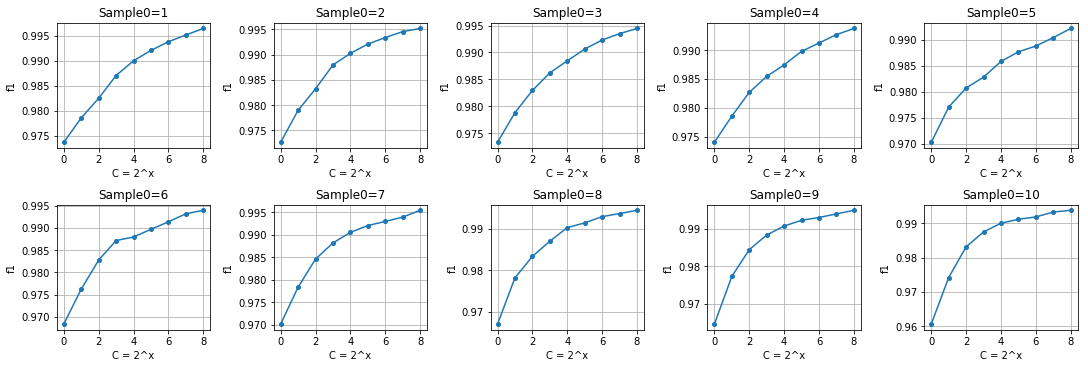

score for all data


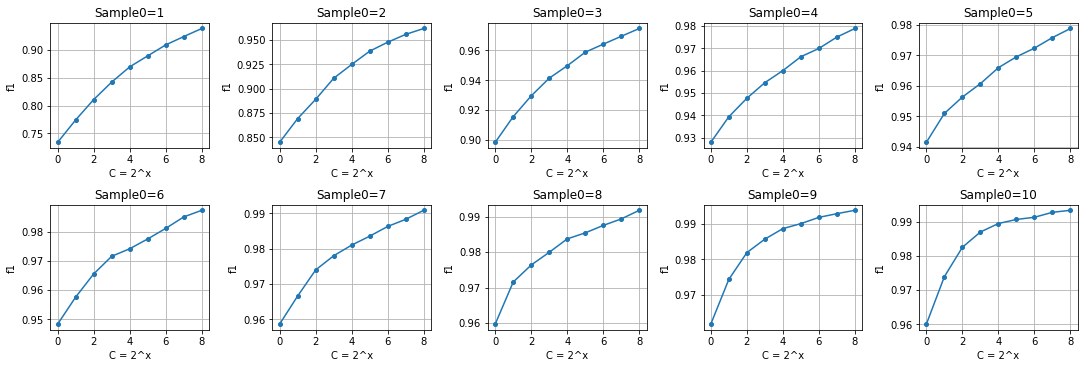

In [94]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

print('score for test data')
figsize = (15, 5)
fig, axs = plt.subplots(np.ceil(len(Times_S)/5).astype(int), 5, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(Times_S))
f1_ay_ = np.array(f1_ay).reshape(-1, len(C_s))

for i,ax in zip(Times_S,axs):
    ax.set_title('Sample0=%s' % str(i))
    ax.set_xlabel('C = 2^x')
    ax.set_ylabel('f1')
    ax.plot(C_s, f1_ay_[i-1], 'o', ls='-', ms=4)
    ax.grid()

plt.show()

print('score for all data')
figsize = (15, 5)
fig, axs = plt.subplots(np.ceil(len(Times_S)/5).astype(int), 5, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(Times_S))
f1_ay0_ = np.array(f1_ay0).reshape(-1, len(C_s))

for i,ax in zip(Times_S,axs):
    ax.set_title('Sample0=%s' % str(i))
    ax.set_xlabel('C = 2^x')
    ax.set_ylabel('f1')
    ax.plot(C_s, f1_ay0_[i-1], 'o', ls='-', ms=4)
    ax.grid()

plt.show()

# The result shows more sim=0 data and higer value of C will get better model.

More analysis

In [95]:
# 1. Analyze the computing distance for match roomtype pairs in room_matches
# 
# Q: Shall we trust/use the label data in room_matches?
# ======================================================================
dm_col_match1_1 = dm_col_sku_match1[dm_col_sku_match1.sim==1].copy()
print('1. rowcount of roomtype pairs in room_matches:            ', dm_col_match1_1.shape[0])

dm_col_match2_1 = dm_col_sku_match2[dm_col_sku_match2.sim==1].copy()
print('2. rowcount of roomtype pairs in by computing (dist<0.3): ', dm_col_match2_1.shape[0])

dm_sku_match_1 = pd.merge(dm_col_match1_1, dm_col_match2_1, how='inner', 
                        left_on =['skugroupid_1','roomtypeid_1','skugroupid_2','roomtypeid_2'], 
                        right_on=['skugroupid_1','roomtypeid_1','skugroupid_2','roomtypeid_2'],
                        suffixes=('_1', '_2'))
print('3. rowcount of roomtype pairs satisfied 1 and 2:          ', dm_sku_match_1.shape[0])

1. rowcount of roomtype pairs in room_matches:             17258
2. rowcount of roomtype pairs in by computing (dist<0.3):  10974
3. rowcount of roomtype pairs satisfied 1 and 2:           3203


In [96]:
# 2. Analyze if we can use predict_proba as score and compared with similarity matrix.
#
# Q: Can we adjust model by changing value of proba_1?
dm_col_match2 = dm_col_sku_match2.copy()
X, y = dm_col_match2.values[:,4:-1], dm_col_match2.values[:,-1]
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=2)

lr2 = LogisticRegression(solver='liblinear', multi_class='ovr', C=64)
lr2.fit(trainX, trainy)

X0, y0 = dm_col_sku_match2.values[:,4:-1], dm_col_sku_match2.values[:,-1]
tn, fp, fn, tp = confusion_matrix(y0, lr2.predict(X0)).ravel()
pre = tp/(tp+fp)
rec = tp/(tp+fn)
f1_score  = 2 * pre * rec / (pre + rec)

df_proba = pd.DataFrame(lr2.predict_proba(X0), columns=['proba_0','proba_1'])
pd.concat([dm_sku_match2, df_proba], axis=1).head(10)

,skugroupid_1,roomtypeid_1,skugroupid_2,roomtypeid_2,dist,sim,proba_0,proba_1
0,195,72143,123167,60124,0.435897,0,1.000000e+00,1.656155e-19
1,195,72143,123167,60128,0.230769,1,2.912217e-10,1.000000e+00
2,195,72143,123167,201432386,0.269231,1,5.761299e-05,9.999424e-01
3,195,72146,123167,60124,0.286935,1,1.670203e-02,9.832980e-01
4,195,72146,123167,60128,0.382418,0,1.000000e+00,4.113467e-12
5,195,72146,123167,201432386,0.420879,0,1.000000e+00,2.079152e-17
6,195,200053436,123167,60124,0.286935,1,1.670203e-02,9.832980e-01
7,195,200053436,123167,60128,0.382418,0,1.000000e+00,4.113467e-12
8,195,200053436,123167,201432386,0.420879,0,1.000000e+00,2.079152e-17
9,195,200053439,123167,60124,0.516484,0,1.000000e+00,1.167955e-30
